# MVPA fMRI pipeline

Note: this pipeline requires single-trial estimates (beta or t images) for each subject. If these aren't available to you, please run the pipeline_glms_fmri.m MATLAB script which creates these images (among others) from preprocessed fMRI data

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt 
# from niwidgets import NiftiWidget 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import nibabel as nib
import os 
import pickle
from IPython.core.debugger import set_trace
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

In [ ]:
def load_mask(mask_name, mask_dir):
    """loads volume mask 
       and casts to float array with 1,nan

    Args:
        mask_name (str): file name
        mask_dir (str): path to mask
    """
    mask = nib.load(mask_dir+mask_name).get_data()
    mask = mask.astype(np.float32)
    mask[mask == 0] = np.nan
    return mask


def load_run(sub_id, run_id, condition_vars, mask,whichfeatures='tmaps'):
    """loads nifti images and trial ids for 
       a single run.

    Args:
        sub_id (int): subject identifier
        run_id (int): run identifier
        condition_vars (dict): dictionary with trial identifiers
        mask (np.array): mask for brain volume 
    """
    # get condition indices
    bs = condition_vars['branchiness'][sub_id-1,
                                       condition_vars['block'][sub_id-1, :] == run_id][:,np.newaxis]
    ls = condition_vars['leafiness'][sub_id-1,
                                     condition_vars['block'][sub_id-1, :] == run_id][:,np.newaxis]
    cs = condition_vars['correct'][sub_id-1, condition_vars['block'][sub_id-1, :] == run_id][:,np.newaxis]
    rs = condition_vars['response'][sub_id-1,
                                     condition_vars['block'][sub_id-1, :] == run_id][:,np.newaxis]
    ts = condition_vars['task'][sub_id-1, condition_vars['block'][sub_id-1, :] == run_id][:,np.newaxis]

    # load features and mask them
    if whichfeatures=='tmaps':
        idx_min = 0+100*(run_id-1)
        idx_max = 100*run_id
        features = []
        for i in range(idx_min, idx_max):
            # import raw data
            img = nib.load(datadir+subjectfolder(sub_id) +
                        f'spmT_{(i+1):04d}.nii').get_data()
            # include only masked voxels
            img = img[mask == 1]
            # flatten and store
            features.append(img.flatten())
        features = np.asarray(features)

    elif whichfeatures=='betas':
        idx_min = 0+100*(run_id-1)+6*(run_id-1)
        idx_max = 100*run_id+6*(run_id-1)
        features = []
        for i in range(idx_min, idx_max):
            # import raw data
            img = nib.load(datadir+subjectfolder(sub_id) +
                        f'beta_{(i+1):04d}.nii').get_data()
            # include only masked voxels
            img = img[mask == 1]
            # flatten and store
            features.append(img.flatten())
        features = np.asarray(features)

    return features, bs, ls, cs, rs, ts


def load_traintestdata_runs(mask,condition_variables,sub_id,test_run,whichfeatures='tmaps'):
    """gathers data for training and test sets, 
       where all but test_run in training set and test_run in test set
       

    Args:
        mask (np.array): mask of voxels to include
        condition_variables (dict): dictionary with behavioural data
        sub_id (int): id of subject whose data to load
        test_run (int): id of run for test set
    """
    n_runs = 6 # this is fixed for my study
    all_runs = np.arange(1,7)
    training_runs = all_runs[all_runs!=test_run]
    # load test data 
    features_test, bs_test, ls_test, cs_test, rs_test, ts_test = load_run(sub_id,test_run,condition_variables,mask,whichfeatures=whichfeatures)

    # load training data
    features_train, bs_train, ls_train, cs_train, rs_train, ts_train = load_run(sub_id,training_runs[0],condition_variables,mask,whichfeatures=whichfeatures)
    for tr in training_runs[1:]:
        features, bs, ls, cs, rs, ts = load_run(sub_id,tr,condition_variables,mask,whichfeatures=whichfeatures)
        features_train = np.concatenate((features_train,features),axis=0)
        bs_train = np.concatenate((bs_train,bs),axis=0)
        cs_train = np.concatenate((cs_train,cs),axis=0)
        rs_train = np.concatenate((rs_train,rs),axis=0)
        ts_train = np.concatenate((ts_train,ts),axis=0)
        ls_train = np.concatenate((ls_train,ls),axis=0)
    labels_test = np.concatenate([ts_test,bs_test,ls_test,rs_test,cs_test],axis=1)
    
    labels_train = np.concatenate([ts_train,bs_train,ls_train,rs_train,cs_train],axis=1)
    return features_train,labels_train, features_test,labels_test



def partition_datasets(features,labels):
    """generates vector with targets
       note: task A/1 : leafiness relevant. task B/2: branchiness relevant
    """
    datasets = {}
    # train task A relevant dim (leafiness):
    datasets['taskA_reldim'] = {}    
    X = features[labels[:,0]==1]
    targets = labels[labels[:,0]==1,2]
    good_trials = targets!=3
    targets = targets>3 # low vs high leafiness    
    X = X[good_trials]
    targets = targets[good_trials]
    datasets['taskA_reldim']['X'] = X
    datasets['taskA_reldim']['y'] = targets 

    
    # train task B reldim (branchiness):
    datasets['taskB_reldim'] = {}
    X = features[labels[:,0]==2]
    targets = labels[labels[:,0]==2,1]
    good_trials = targets!=3
    targets = targets>3 # low vs high leafiness    
    X = X[good_trials]
    targets = targets[good_trials]
    datasets['taskB_reldim']['X'] = X
    datasets['taskB_reldim']['y'] = targets 


    # train task A irreldim (branchiness):
    datasets['taskA_irreldim'] = {}    
    X = features[labels[:,0]==1]
    targets = labels[labels[:,0]==1,1]
    good_trials = targets!=3
    targets = targets>3 # low vs high leafiness    
    X = X[good_trials]
    targets = targets[good_trials]
    datasets['taskA_irreldim']['X'] = X
    datasets['taskA_irreldim']['y'] = targets 
    
    # train task B irreldim (leafiness):
    datasets['taskB_irreldim'] = {}
    X = features[labels[:,0]==2]
    targets = labels[labels[:,0]==2,2]
    good_trials = targets!=3
    targets = targets>3 # low vs high leafiness    
    X = X[good_trials]
    targets = targets[good_trials]
    datasets['taskB_irreldim']['X'] = X
    datasets['taskB_irreldim']['y'] = targets     


    # task A vs task B
    datasets['AvsB'] = {}
    datasets['AvsB']['X'] = features
    datasets['AvsB']['y'] = labels[:,0]

    return datasets


def gen_traintestdata_runs(mask,condition_variables,sub_id,test_run,whichfeatures='tmaps'):
    """loads and partitions the data into sets for training 
       and test. labels are given for the relevant and irrelevant 
       feature dimension of each task.

    Args:
        test_run (int): id of held-out run for leave-one-run-out testing
    """
    features_train,labels_train, features_test,labels_test = load_traintestdata_runs(mask,condition_variables,sub_id,test_run,whichfeatures=whichfeatures)

    datasets_train = partition_datasets(features_train,labels_train)
    datasets_test = partition_datasets(features_test,labels_test)
    return datasets_train, datasets_test

def fit_linear_svm(roi, sub_id, condition_variables, maskdir, featuredim, C=1.0, whichfeatures='tmaps',do_pca=False):
    """trains and evaluates linear svm on fmri roi patterns 
       with 6-fold leave-one-run-out cross-validation

    Args:
        roi (str): ROI to load
        sub_id (int): subject identifier
        condition_variables (dict): behavioural data for conditions
        maskdir (str): path to roi masks
        featuredim (str): dictionary key for feature to fit (for example taskA_reldim)
        C (float): inverse regularisation strength (c in (0,1))

    Returns:
        results: dictionary with training and test accuracies
    """

    # print(f'iterating over subject {sub_id}' )
    # load training and test data
    test_accs = []
    train_accs = []
    for run_id in range(5):
        testaccs = []
        datasets_train, datasets_test = gen_traintestdata_runs(load_mask(
            mask_name=roi+str(sub_id)+'.nii', mask_dir=maskdir), condition_variables, sub_id, run_id+1, whichfeatures=whichfeatures)
        # train on A, relevant (leafiness)
        sc = StandardScaler()
        clf = SVC(C=C,kernel='linear')
        X = datasets_train[featuredim]['X']
        if do_pca:
            pca = PCA(n_components=0.90,svd_solver='full')
            X = pca.fit_transform(X)
        
        X = sc.fit_transform(X)
        y = datasets_train[featuredim]['y']
        clf.fit(X, y)
        yt = clf.predict(X)
        train_accs.append(np.mean(yt == y))

        # test on all four test sets (A rel, B rel, A irrel, B irrel)
        for _, testset in datasets_test.items():
            X = testset['X']
            if do_pca:
                X = pca.transform(X)
            X = sc.transform(X)
            y = testset['y']
            yt = clf.predict(X)
            testaccs.append(np.mean(y == yt))
        test_accs.append(testaccs)
    train_accs = np.asarray(train_accs)
    test_accs = np.asarray(test_accs)
    # average over cross-val folds:
    results = {'train_accs': np.mean(train_accs),
               'test_accs': np.mean(test_accs, 0)
               }

    return results


def plot_avg_svm_results(results):
    # loop over training dimensions
    mm = 1/25.4
    f,axs = plt.subplots(1,len(rois),figsize=(150*mm,50*mm),dpi=300)
    axs = axs.ravel()
    for j,roi in enumerate(rois): # for each roi
        # same task, relevant:            
        # (0,0),(1,1)    
        # same task, irrelevant: 
        # (0,2),(1,3)
        # other task, relevant: 
        # (0,1),(1,0)
        # other task, irrelevant:
        # (0,3),(1,2)
        idces = [(0,0),(1,1)],[(0,2),(1,3)],[(0,1),(1,0)],[(0,3),(1,2)]
        for k,idx in enumerate(idces):
            avg_res = (results[j,idx[0][0],:,idx[0][1]]+results[j,idx[1][0],:,idx[1][1]])/2           
        
            axs[j].bar(k,avg_res.mean()-0.5,yerr=np.std(avg_res)/np.sqrt(31),color=(0.5,0.7,0.4),edgecolor='k')
            axs[j].scatter(np.repeat(k,31)+0.1+np.random.randn(31)*0.01,avg_res-0.5,color=(.9,.9,.9),alpha=0.4,zorder=3,s=2,edgecolors='k',linewidth=0.5)
            axs[j].plot([-1,4],[0,0],'k--',linewidth=0.5)
            t,p = ttest_1samp(avg_res,0.5)
            
            print(''.join((roi.split('_')[0].split('t')[1:])) + f': \t t= {t:.2f}, \t p= {p:.4f} mu={avg_res.mean()-0.5:.4f}')
            if t>0 and p<0.05:
                if p <(0.0001/4):
                    ts = '*'*4
                elif p <(0.001/4):
                    ts = '*'*3
                elif p<(0.01/4):
                    ts = '*'*2
                elif p<(0.05/4):
                    ts = '*'
                else:
                    ts =''
                axs[j].text(k,0.2,ts,{'fontsize':6,'ha':'center','fontweight':'normal'})

        axs[j].set_xlabel('test dimension',fontsize=6)
        axs[j].set_ylabel('test acc - chance (%)',fontsize=6)
        axs[j].set_title(''.join((roi.split('_')[0].split('t')[1:])),fontsize=6)
        axs[j].set_ylim(-0.10,0.2)
        axs[j].set_xticks(np.arange(4))
        axs[j].set_xticklabels(['same task rel','same task irrel', 'other task rel', 'other task irrel'],rotation=90,fontsize=6)
        axs[j].set_yticks(ticks=[-0.1,0,0.1,0.2])
        axs[j].set_yticklabels(np.round(np.array([-0.1,0,0.1,0.2])*100,2),fontsize=6)
        axs[j].spines['top'].set_visible(False)
        axs[j].spines['right'].set_visible(False)
        
    
    plt.suptitle('Decoding Results',fontsize=6)
    plt.tight_layout()


In [4]:
# data folders. subdirectories & subject indices 
datadir = ''
subjectfolder = lambda x : 'TIMO'+f'{x:03d}/dmats/'
badsubs = [28]
behavdir = ''
subjects = np.arange(1,33)
subjects = subjects[subjects!=badsubs]
# (roi) mask dirs:
maskdir = ''
groupmask = 'groupMask_cval_searchlight.nii' 
rois = ['leftEVC_all7mods_mod5_sub','rightDLPFC_all7mods_mod3_sub','rightMCC_all7mods_mod3_sub','rightPAR_all7mods_mod3_sub']


In [3]:
# load behav data:
condition_variables = loadmat(behavdir+'condition_variables.mat')

In [77]:
datasets_train, datasets_test = gen_traintestdata_runs(load_mask(
            mask_name=rois[0]+str(1)+'.nii', mask_dir=maskdir), condition_variables, 1, 1, whichfeatures='tmaps')
for k,_ in datasets_test.items():
    print(k)
datasets_train['taskA_reldim']['X'].shape
sc = StandardScaler()
X = sc.fit_transform(datasets_train['taskA_reldim']['X'])
pca = PCA(n_components=0.95,svd_solver='full')
x1 = pca.fit_transform(X)
x1.shape

cs = [1]
dims = ['taskA_reldim', 'taskB_reldim']
all_train_accs = np.empty((len(rois), len(cs), len(dims), 31))
all_test_accs = np.empty((len(rois), len(cs), len(dims), 31, 5))
for i, roi in enumerate(rois):
    for j, C in enumerate(cs):
        for k, d in enumerate(dims):
            results = Parallel(n_jobs=6, backend='loky', verbose=1)(delayed(fit_linear_svm)(
                roi, sub_id, condition_variables, maskdir, d, C=C, whichfeatures='tmaps',do_pca=True) for sub_id in subjects)
            all_train_accs[i, j, k, :] = np.asarray(
                [r['train_accs'] for r in results])
            all_test_accs[i, j, k, :, :] = np.asarray(
                [r['test_accs'] for r in results])

results = {'train_accs': all_train_accs,
           'test_accs': all_test_accs,
           'dims': dims,
           'rois': rois,
           'regularisers': cs
           }

with open('results_linearsvm_fmri_tmaps_pca.pkl', 'wb') as f:
    pickle.dump(results,f)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   46.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   46.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   48.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   47.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   47.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   48.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  31 out of  31 | elapsed:   

EVC: 	 t= 8.99, 	 p= 0.0000 mu=0.0665
EVC: 	 t= 1.73, 	 p= 0.0941 mu=0.0119
EVC: 	 t= 0.88, 	 p= 0.3856 mu=0.0082
EVC: 	 t= 8.44, 	 p= 0.0000 mu=0.0615
DLPFC: 	 t= 4.41, 	 p= 0.0001 mu=0.0319
DLPFC: 	 t= 0.22, 	 p= 0.8238 mu=0.0012
DLPFC: 	 t= -0.18, 	 p= 0.8562 mu=-0.0012
DLPFC: 	 t= 2.32, 	 p= 0.0275 mu=0.0098
MCC: 	 t= 5.54, 	 p= 0.0000 mu=0.0398
MCC: 	 t= 0.30, 	 p= 0.7698 mu=0.0016
MCC: 	 t= -0.40, 	 p= 0.6952 mu=-0.0032
MCC: 	 t= 1.22, 	 p= 0.2327 mu=0.0052
PAR: 	 t= 4.13, 	 p= 0.0003 mu=0.0273
PAR: 	 t= 0.74, 	 p= 0.4649 mu=0.0038
PAR: 	 t= 0.13, 	 p= 0.8975 mu=0.0010
PAR: 	 t= 1.85, 	 p= 0.0736 mu=0.0092


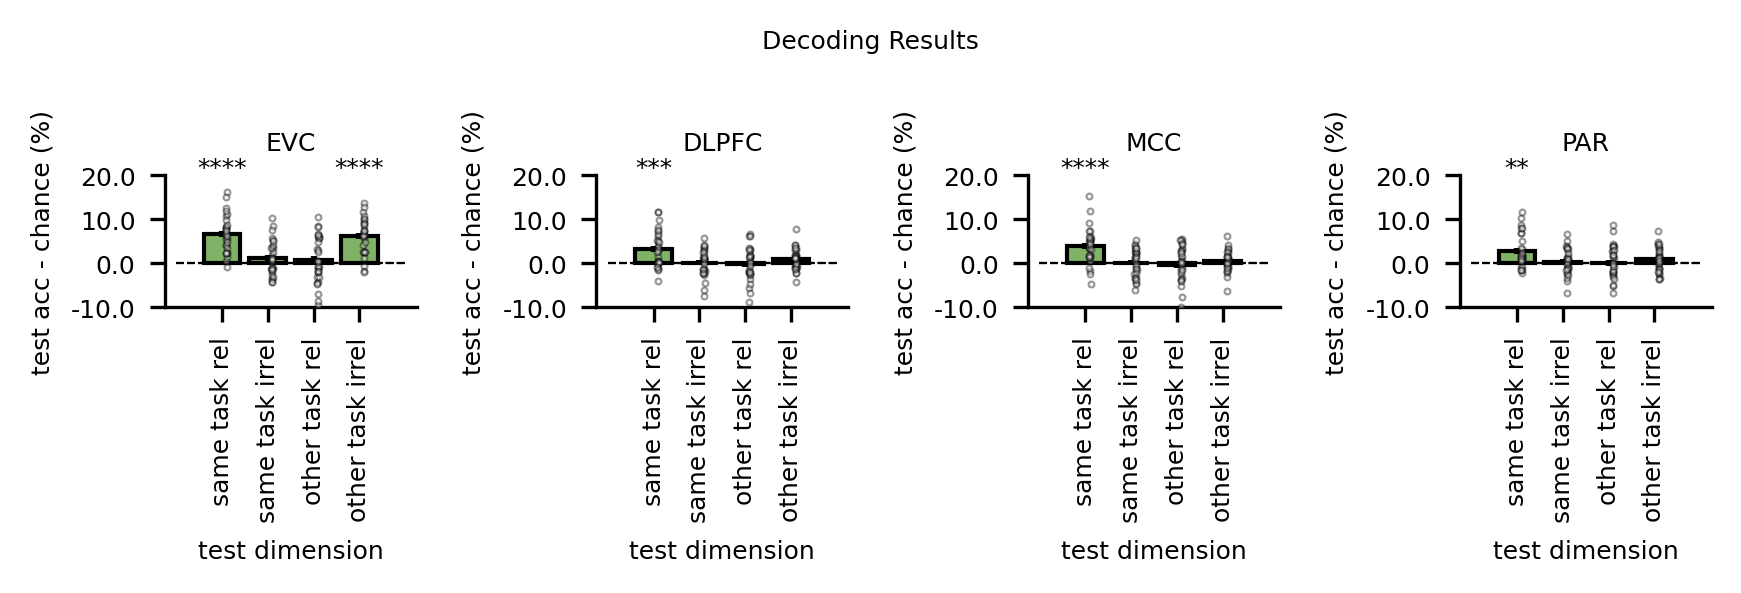

In [29]:
with open('results_linearsvm_fmri_tmaps_pca.pkl', 'rb') as f:
    results = pickle.load(f)
from scipy.stats import ttest_1samp 
dims_train =  ['taskA_reldim', 'taskB_reldim']
dims_test = ['taskA_reldim', 'taskB_reldim','taskA_irreldim', 'taskB_irreldim']
%matplotlib inline
plot_avg_svm_results(results['test_accs'][:,0,:,:,:])
